<a href="https://colab.research.google.com/github/rafatb/Berlin_Airbnb_Price_Prediction/blob/main/Berlin_Airbnb_Price_Prediction_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
# from google.colab import drive
# drive.mount('/content/drive')

In [141]:
# !pip install missingno
# !pip install autoviz
# !pip install geopy
# !pip install scipy
# !pandas_profiling
# !pip install statsmodels
# !pip install pyodbc
# !pip install seaborn
# !pip install nltk


In [142]:
import numpy as np
import os
import pandas as pd
#from pandas_profiling import ProfileReport
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import ensemble, tree, linear_model
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from scipy.stats import pearsonr
import pyodbc
import seaborn as sns
sns.set()
plt.style.use('ggplot')
import re
from scipy import stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from scipy.stats import norm
import missingno as msno
import warnings
import datetime
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import nltk

In [143]:
df = pd.read_pickle('/content/drive/MyDrive/kaggle/berline/ready_for_eda.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Listing ID                      23536 non-null  int64         
 1   Overall Rating                  18914 non-null  float64       
 2   Accuracy Rating                 18888 non-null  float64       
 3   Cleanliness Rating              18892 non-null  float64       
 4   Checkin Rating                  18870 non-null  float64       
 5   Communication Rating            18886 non-null  float64       
 6   Location Rating                 18871 non-null  float64       
 7   Value Rating                    18868 non-null  float64       
 8   Price                           23536 non-null  float64       
 9   Square Feet                     425 non-null    float64       
 10  Reviews                         23536 non-null  float64       
 11  re

In [144]:
df.shape

(23536, 35)

#Data Protocol
###Exporting results to the protocol

In [145]:
# Type of valaues
df.dtypes.to_excel("berline_datatype.xlsx",
             sheet_name='data_type')
# Maximum valaues
df.select_dtypes(include=['float','int','category']).max().to_excel("max_berline.xlsx",
             sheet_name='max')
# Minimum Values
df.select_dtypes(include=['float','int','category']).min().to_excel("min_berline.xlsx",
             sheet_name='min')
# Missing Values
df.isnull().sum(axis=0).to_excel("NA_berline.xlsx",
             sheet_name='NA')
# exporting results to the protocol
df.nunique().to_excel("unique_berline.xlsx",
             sheet_name='unique')

#Transform data

In [146]:
df['year'] = df['review_date'].dt.year
df['month'] = df['review_date'].dt.month
df['day'] = df['review_date'].dt.day
df.drop(columns=['review_date'], inplace=True)

#TBD need to drop it in the prep
df.drop(['Neighborhood Group'], axis=1, inplace=True)
df['Host Since'] = pd.to_datetime(df['Host Since']).dt.year


### move out non relevant data for the

In [147]:
#get dummies
df_dummy = df[[col for col in df if np.isin(df[col].dropna().unique(), [0, 1]).all()]]
df_dummy.columns

Index(['Is Superhost', 'Instant Bookable', 'Is Exact Location'], dtype='object')

In [148]:
#get all numeric data
cols = df.columns
df_num = df._get_numeric_data().columns.dropna().unique()
df_num

Index(['Listing ID', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating',
       'Checkin Rating', 'Communication Rating', 'Location Rating',
       'Value Rating', 'Price', 'Square Feet', 'Reviews', 'Bedrooms', 'Beds',
       'Bathrooms', 'Host Response Rate', 'Is Superhost', 'Latitude',
       'Longitude', 'Accomodates', 'Guests Included', 'Min Nights',
       'Instant Bookable', 'Host Since', 'Is Exact Location',
       'Overall Rating Cleansed', 'year', 'month', 'day'],
      dtype='object')

In [149]:
pd.set_option('display.max_columns', None)
df_num_non_dummy = df[list(set(df_num)-set(df_dummy.columns))]
df_num_non_dummy.drop(['Listing ID'], axis=1, inplace=True)
df_num_non_dummy.columns


Index(['Host Since', 'day', 'Bathrooms', 'Communication Rating',
       'Guests Included', 'Accuracy Rating', 'Min Nights', 'Bedrooms',
       'Location Rating', 'Overall Rating Cleansed', 'Cleanliness Rating',
       'Latitude', 'Value Rating', 'Overall Rating', 'year', 'month',
       'Reviews', 'Longitude', 'Price', 'Square Feet', 'Host Response Rate',
       'Checkin Rating', 'Beds', 'Accomodates'],
      dtype='object')

In [150]:
#get categorial data
df_categorial=df[list(set(cols) - set(df_num))]
df_categorial.columns

Index(['Host Response Rate Cleansed', 'Property Type', 'Host Response Time',
       'Property Type Cleansed', 'Room Type', 'neighbourhood',
       'Neighbourhood Grouped Cleansed', 'Postal Code'],
      dtype='object')

In [151]:
df.describe()

,Listing ID,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price,Square Feet,Reviews,Bedrooms,Beds,Bathrooms,Host Response Rate,Latitude,Longitude,Accomodates,Guests Included,Min Nights,Host Since,Overall Rating Cleansed,year,month,day
count,2.353600e+04,18914.000000,18888.000000,18892.000000,18870.000000,18886.000000,18871.000000,18868.000000,23536.000000,425.000000,23536.000000,23516.000000,23501.000000,23507.000000,13046.000000,23536.000000,23536.000000,23536.000000,23536.000000,23536.000000,23515.000000,18914.000000,19380.000000,19380.000000,19380.000000
mean,1.778264e+07,94.564344,9.679850,9.334904,9.728829,9.746479,9.550315,9.417638,69.612424,487.131765,19.238826,1.161720,1.641802,1.095971,91.842174,52.509906,13.406193,2.671737,1.346151,6.897774,2014.832107,9.691657,2018.097162,5.526109,15.187719
std,9.887995e+06,7.599949,0.737798,1.031248,0.695275,0.679600,0.748713,0.840456,216.660408,517.652098,40.360483,0.660736,1.228642,0.346150,19.447852,0.031279,0.058574,1.567812,0.856297,24.879032,2.056127,0.757756,1.186035,2.915496,9.248955
min,2.695000e+03,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.345800,13.097180,1.000000,1.000000,1.000000,2008.000000,2.000000,2011.000000,1.000000,1.000000
25%,9.056046e+06,92.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,32.000000,0.000000,1.000000,1.000000,1.000000,1.000000,95.000000,52.489177,13.375730,2.000000,1.000000,2.000000,2013.000000,10.000000,2018.000000,4.000000,7.000000
50%,1.874818e+07,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,49.000000,420.000000,5.000000,1.000000,1.000000,1.000000,100.000000,52.509210,13.416575,2.000000,1.000000,3.000000,2015.000000,10.000000,2019.000000,5.000000,14.000000
75%,2.587987e+07,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,75.000000,753.000000,17.000000,1.000000,2.000000,1.000000,100.000000,52.532670,13.439532,3.000000,1.000000,4.000000,2016.000000,10.000000,2019.000000,8.000000,23.000000
max,3.468232e+07,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9000.000000,4639.000000,545.000000,10.000000,22.000000,8.500000,100.000000,52.651670,13.757640,16.000000,16.000000,1000.000000,2019.000000,10.000000,2019.000000,12.000000,31.000000


In [152]:
df_dummy.describe()

,Is Superhost,Instant Bookable,Is Exact Location
count,23536,23536,23536
unique,2,2,2
top,False,False,True
freq,19969,15658,17649


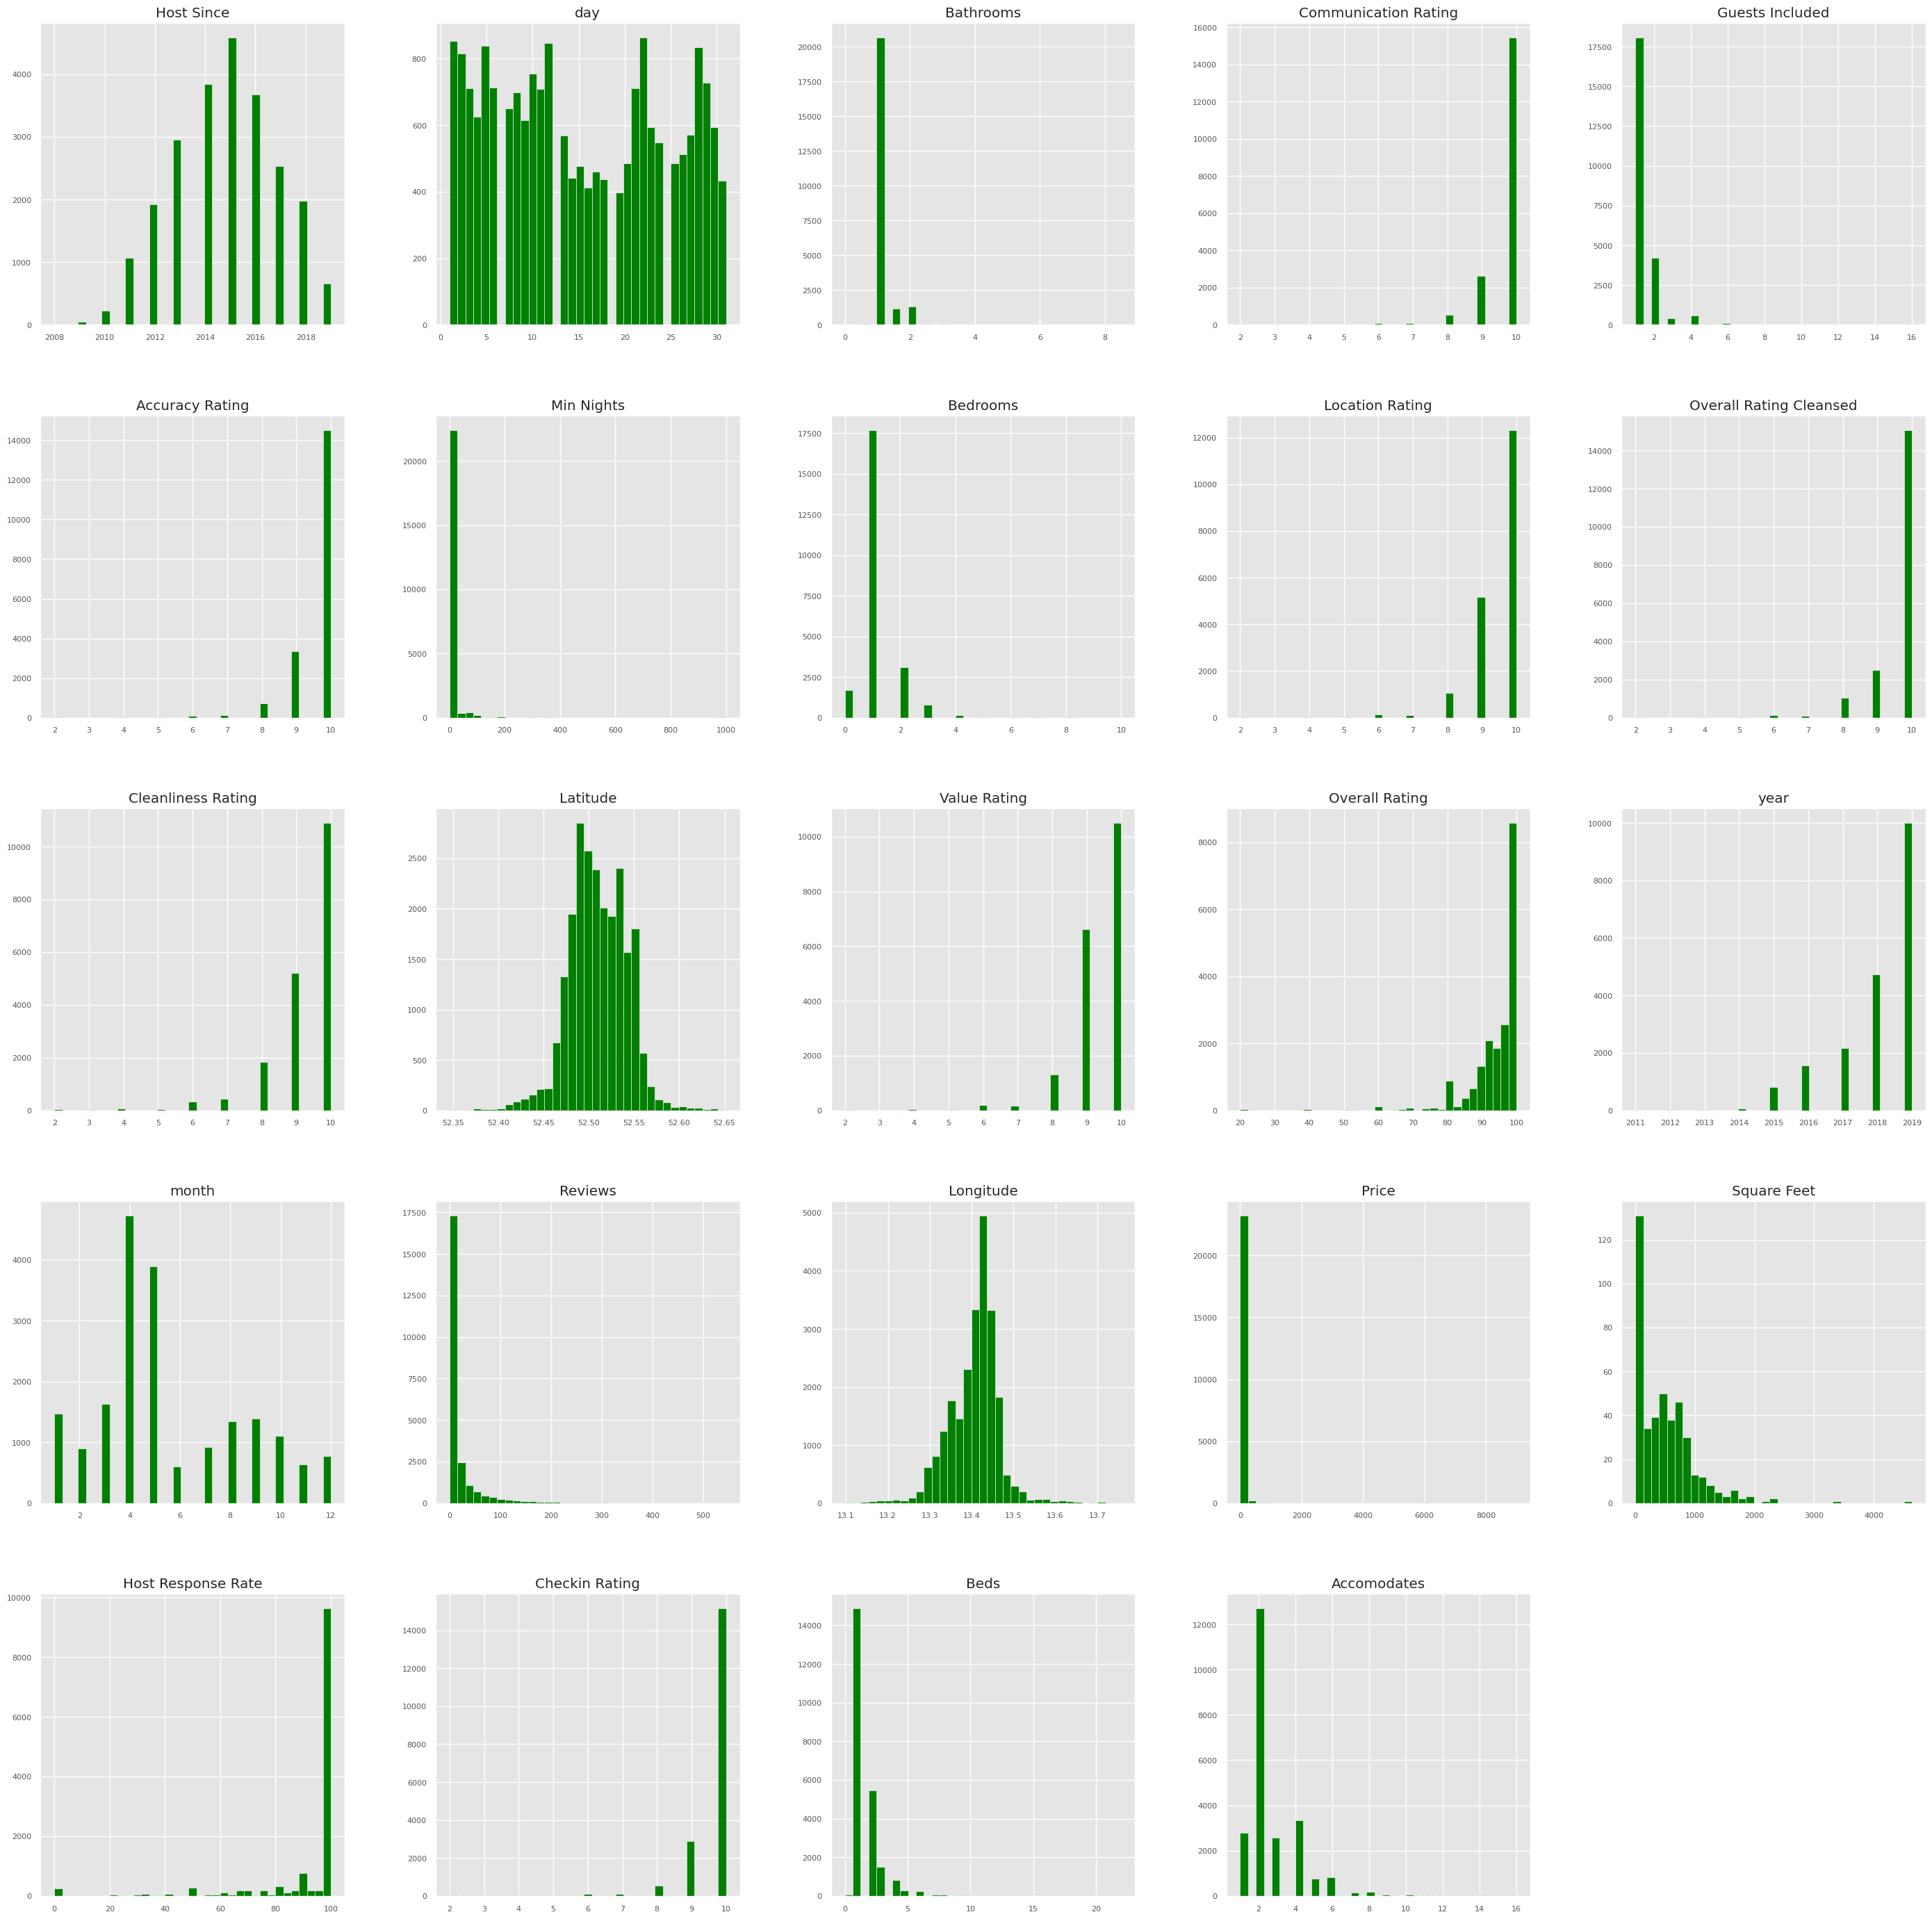

In [153]:
df_num_non_dummy.hist(figsize=(35, 35), bins=35, xlabelsize=8, ylabelsize=8, color = "green");

We can see that data is skewed, let's measure the asymmetry of the distribution:

In [154]:
def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'
    default = ''
    negative = 'background-color: hotpink;'
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative
    #else
       # return default
pd.DataFrame(df_num_non_dummy.skew(),columns=['skewness']).sort_values(by='skewness', ascending=False).style.applymap(highlight)

,skewness
Price,26.846364
Min Nights,21.513526
Bathrooms,6.774987
Guests Included,5.123136
Reviews,4.350674
Beds,3.661029
Accomodates,2.652933
Square Feet,2.326157
Bedrooms,2.235585
month,0.574116


we can see in the pink all the columns are positively skewed (skewness > 1), 9 columns.

in the green we can see columns are negativley skewed (skewness < -1), 10 columns.

later we'll see if outliers or missing values can affect the features distribution.

In [155]:
for i in df_dummy.iloc[:,:3]:
  print(i)



Is Superhost
Instant Bookable
Is Exact Location


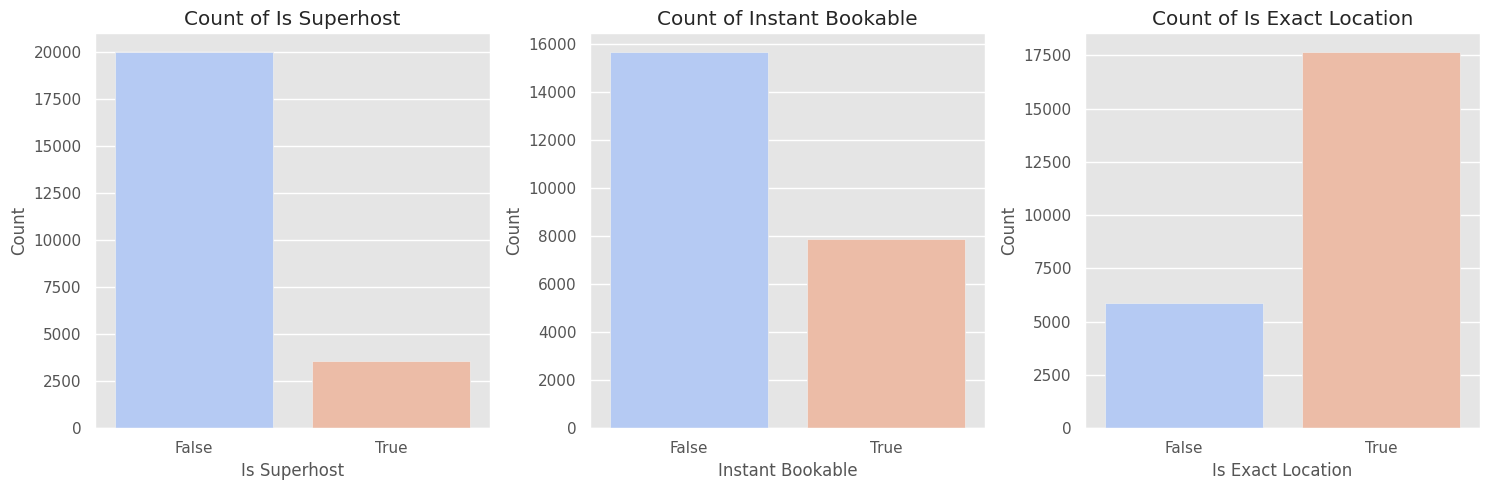

In [156]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through each column and create a count plot
for i, col in enumerate(df_dummy.columns):
    sns.countplot(x=df_dummy[col], ax=axes[i], palette="coolwarm")
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()

In [157]:
df_categorial

,Host Response Rate Cleansed,Property Type,Host Response Time,Property Type Cleansed,Room Type,neighbourhood,Neighbourhood Grouped Cleansed,Postal Code
0,Low Response,Apartment,within a day,Apartment,Private room,Prenzlauer Berg,Pankow,10437
1,Low Response,Apartment,within a day,Apartment,Entire home/apt,Prenzlauer Berg,Pankow,10405
2,Very High Response,Apartment,within an hour,Apartment,Private room,Prenzlauer Berg,Pankow,10437
3,Very High Response,Apartment,within a day,Apartment,Entire home/apt,Prenzlauer Berg,Pankow,10405
4,Very High Response,Apartment,within a day,Apartment,Entire home/apt,Prenzlauer Berg,Pankow,10437
...,...,...,...,...,...,...,...,...
23531,Moderate Response,Apartment,within a few hours,Apartment,Entire home/apt,Wannsee,Steglitz - Zehlendorf,14109
23532,NaN,Apartment,None,Apartment,Private room,Mitte,Mitte,13125
23533,NaN,Apartment,None,Apartment,Private room,Britz,NeukÃ¶lln,12347
23534,NaN,Apartment,None,Apartment,Entire home/apt,KÃ¶penick,Treptow - KÃ¶penick,12555


In [158]:
df_categorial.shape

(23536, 8)

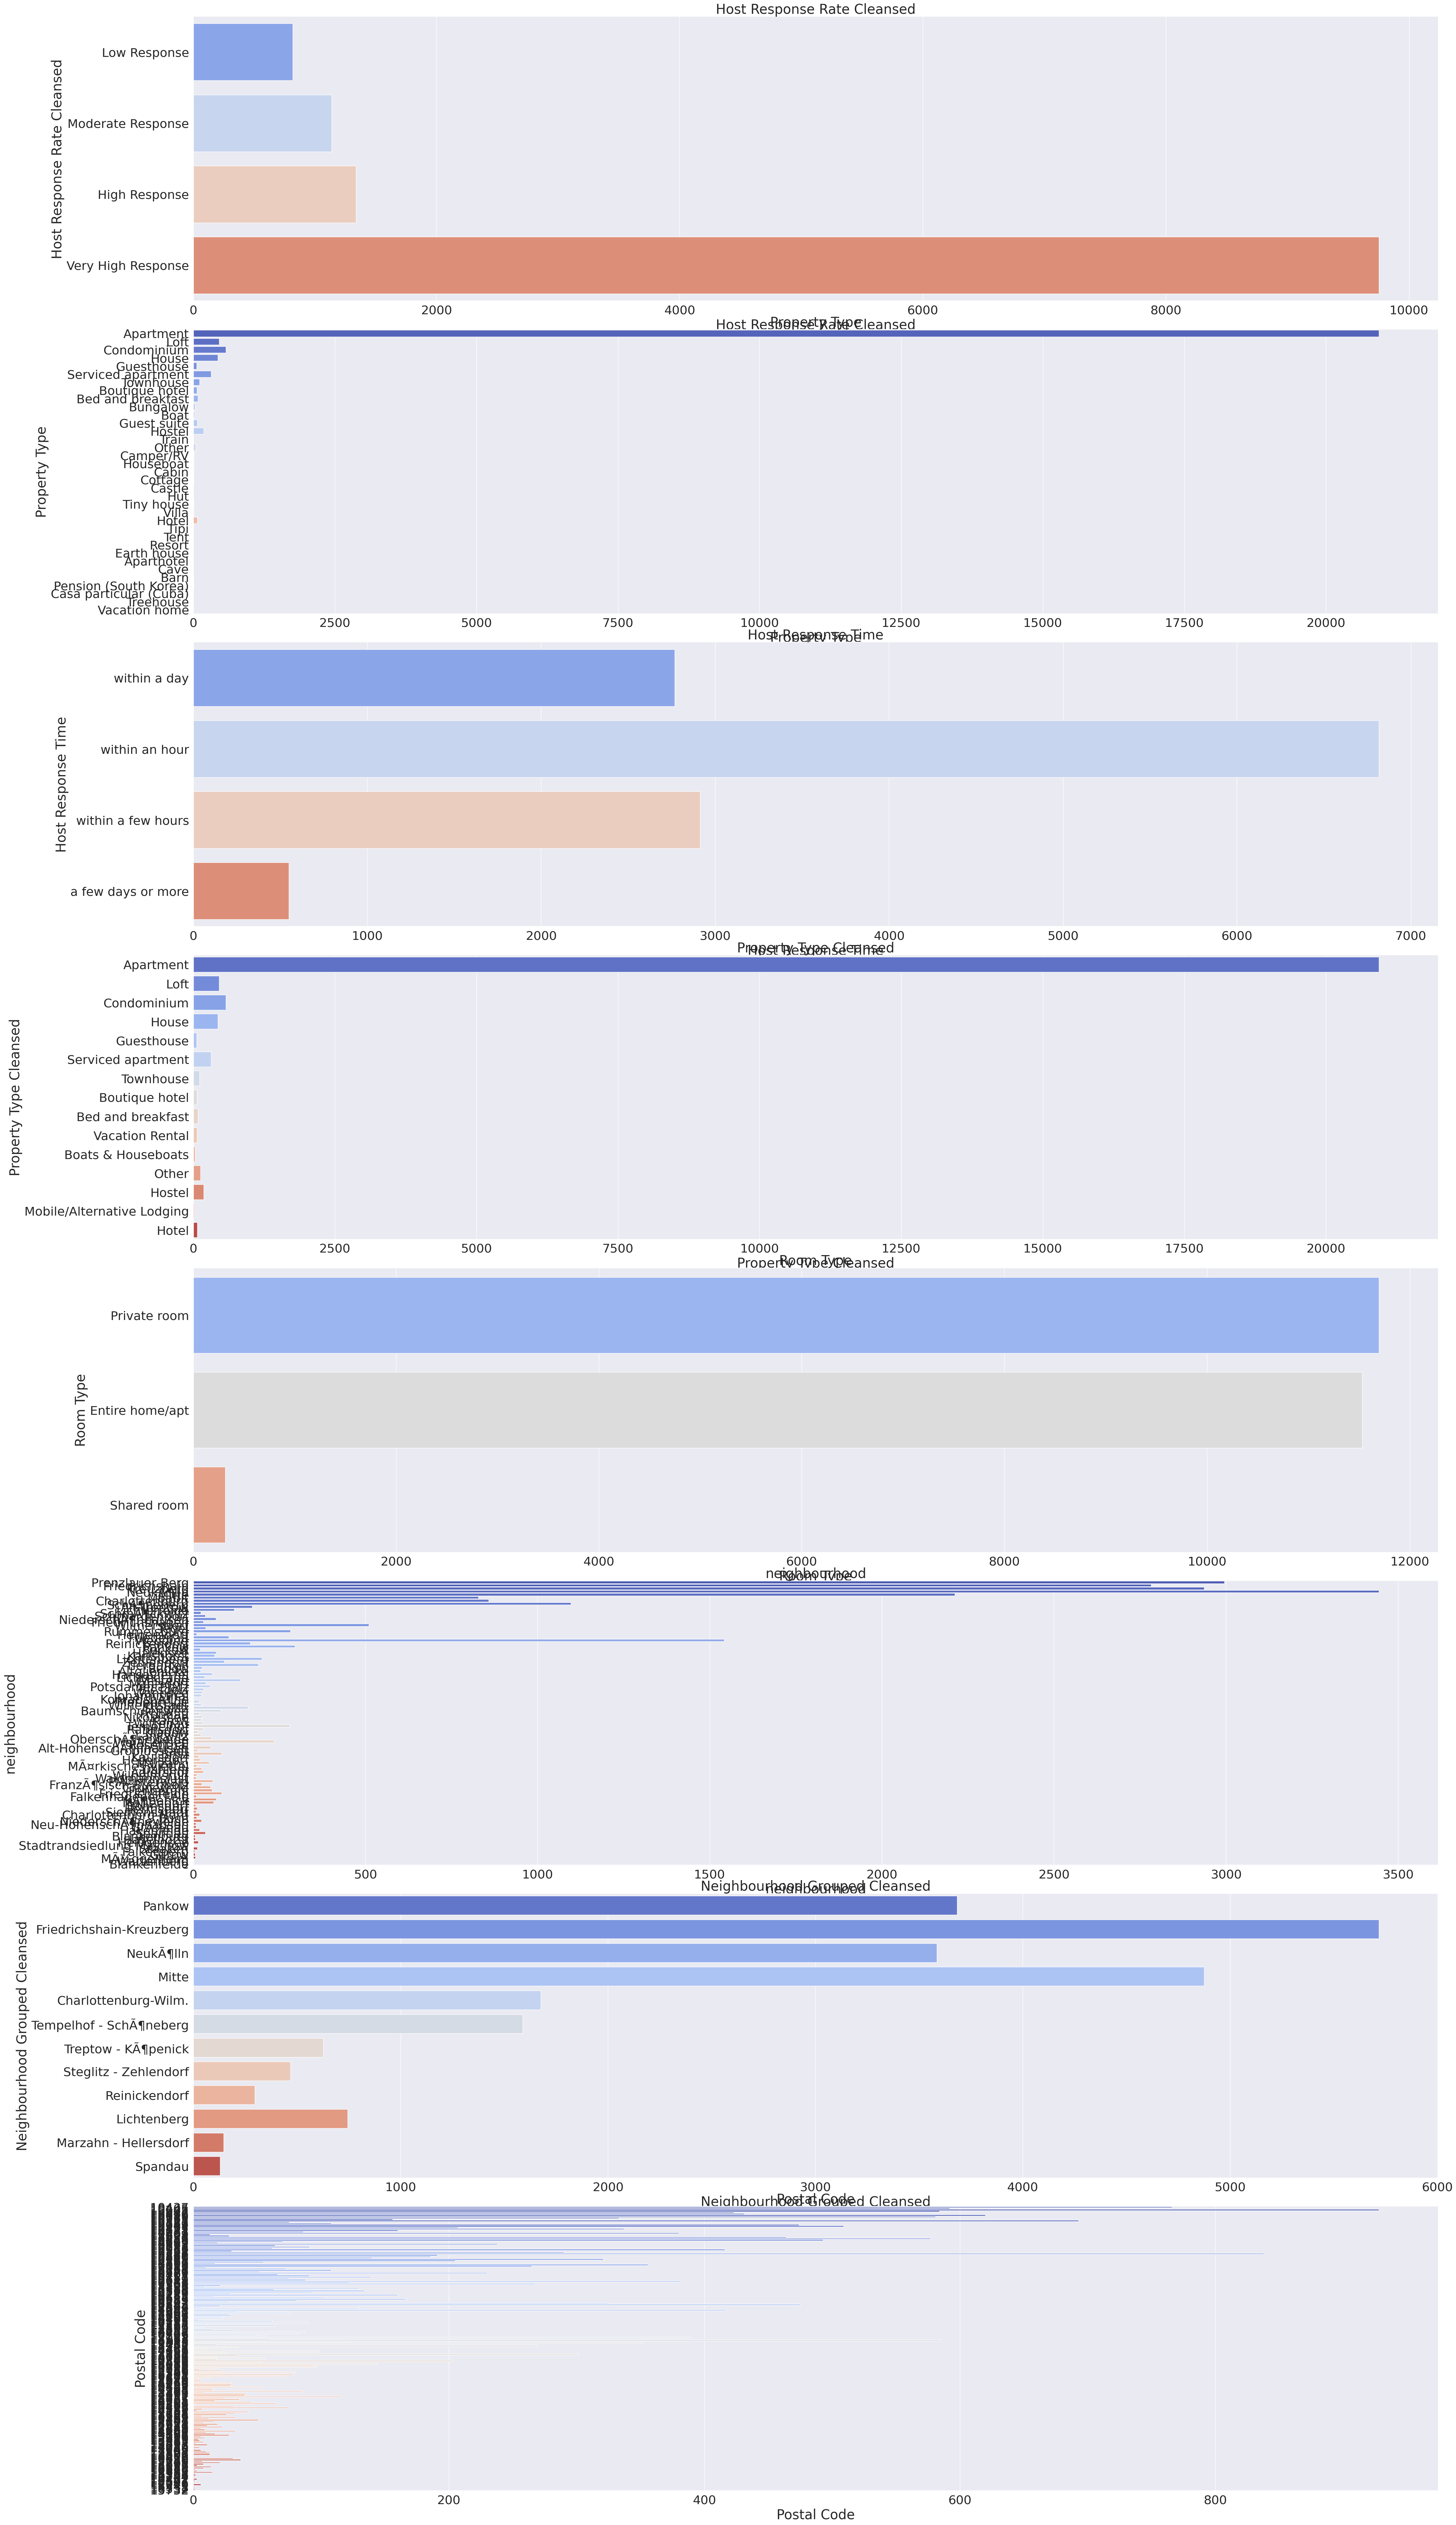

In [170]:
a = 8  # number of rows
b = 1  # number of columns
c = 1  # plot counter

fig = plt.figure(figsize=(50,100))
plt.subplots_adjust(hspace = 0.1)
sns.set(font_scale = 2.5)
for i in df_categorial:

        plt.subplot(a, b, c)
        plt.title('{}'.format(i))
        plt.xlabel(i)
        sns.countplot(df_categorial[i],palette="coolwarm")
        c = c + 1

plt.show()

In [174]:
df['Price'].describe()

,Price
count,23536.000000
mean,69.612424
std,216.660408
min,0.000000
25%,32.000000
50%,49.000000
75%,75.000000
max,9000.000000


we can aee that max price is  9000, but the 75% quantile is 75 ,
so we need to remove the extream values during the outliers phase

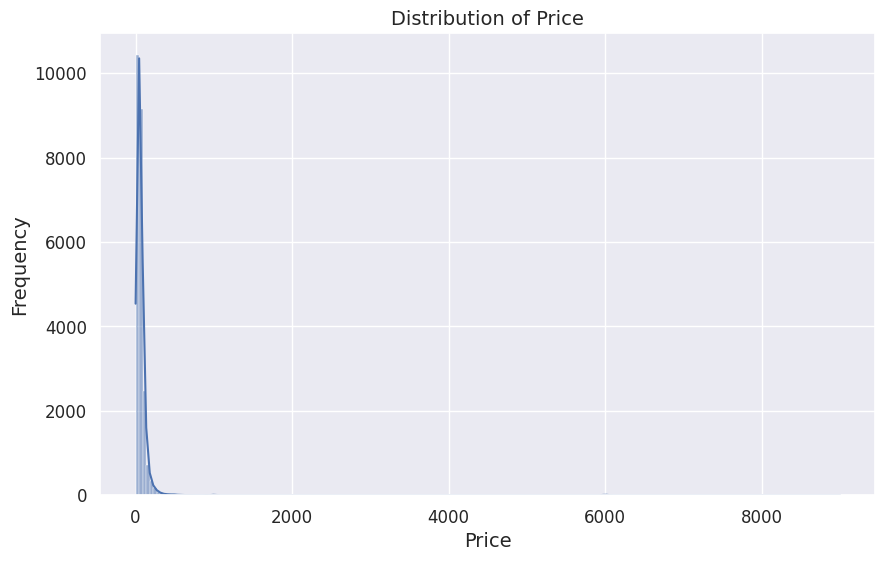

In [185]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=200, kde=True )
plt.title("Distribution of Price",fontsize=14)
plt.xlabel("Price",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.tick_params(axis='both', labelsize=12)  # 'both' for both x and y axis
plt.show()

In [186]:
corr = df.corr(method = 'spearman')
corr.style.background_gradient(cmap='coolwarm').set_precision(4)

ValueError: could not convert string to float: 'Apartment'

In [ ]:
from autoviz.AutoViz_Class import AutoViz_Class
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
AV = AutoViz_Class()

#AV = AutoViz()

# Specify the dataset and target column
# df_av = AV.AutoViz(
#     filename="",  # Leave empty if passing a DataFrame
#     df=df_aggregated,  # Your Pandas DataFrame
#     depVar="Price",  # Specify the target column
#     verbose=2
# )

AV.AutoViz(filename="", sep=",", depVar="Price", dfte=df_aggregated, max_cols_analyzed=10)


In [ ]:
# from geopy.distance import great_circle
# def distance_to_mid(lat, lon):
#     berlin_centre = (52.5027778, 13.404166666666667)
#     accommodation = (lat, lon)
#     return great_circle(berlin_centre, accommodation).km

# df_aggregated['Distance From Center Cleansed'] = df_aggregated.apply(lambda row: round(distance_to_mid(row['Latitude'], row['Longitude']), 1), axis=1)
# bins = [0, 0.5, 1, 2, 4, 8, 16]
# labels = ["Center", "Cercile1 ", "Cercile2", "Cercile4", "Cercile8", "Cercile16"]

# # Apply pd.cut() to create a new binned column
# df_aggregated["Distance From Center Grouped Cleansed"] = pd.cut(df_aggregated["Distance From Center Cleansed"], bins=bins, labels=labels, include_lowest=True)
# # df_aggregated.drop(columns=["Distance From Center Cleansed"], inplace=True)
# # df_aggregated.drop(columns=["Latitude","Longitude"], inplace=True)
